# Single Cell Sequencing: gene discovery exploration

Here we explore the traspose matrix, meaning how genes are close to each other. 

The idea is to explore genes that have similar expression, ergo could have similar funcionality (gene discovery procesure).

For that aim, we normalize each gene counting among cells between 0 and 1, and we reduce the dimensinality using umap transformation. Later we measure distance in the umap space (also could be done in the original space).

For measuring distance at first instance we are using euclidean distance. We have to explore different measures for similarity to check results and expand to other possibles genes. 

We use as an input adata file after quality control : campari_scs.h5ad

In [23]:
!pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
sb.set_context(context='poster')
import config as general_paths
from datetime import date
today = date.today()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.4 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.3 louvain==0.8.0 pynndescent==0.5.10


In [24]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
input_path = output_path
local_path = general_paths.local_path

## SECTION I: Data loading

Loading adata information that has been agregated and quality controled

In [25]:
adata = ad.read_h5ad(os.path.join(input_path , 'campari_scs_umap.h5ad'))

/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## SECTION II: Analysis for gene discovery


In [26]:
#labels=['Control','pinch','new_stroke','ballon','AG','AD','heating','mock','old_stroke','anal_pinch','mock_w_poop','vaginal_distension','tomatoe','poop']

x = adata.X
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
louvain = np.zeros((x.shape[0],6))

for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
    red[i] = adata.obs['red'][i]
    green[i] = adata.obs['green'][i]

In [27]:
### create a umap embedding in the genes x genes space
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap


from scanpy._utils import NeighborsView
neighbors_key = 'neighbors'
neighbors = NeighborsView(adata, neighbors_key)
if 'params' not in neighbors or neighbors['params']['method'] != 'umap':
        logg.warning(
            f'.obsp["{neighbors["connectivities_key"]}"] have not been computed using umap'
        )
n_neighbors = neighbors['params']['n_neighbors']

scaled_data = StandardScaler().fit_transform(x)
scaled_data = (scaled_data.T - np.min(scaled_data, axis = 1))/ (np.max(scaled_data, axis = 1).reshape(-1) - np.min(scaled_data, axis = 1).reshape(-1))

number_of_components = 20
pca1 = PCA(number_of_components)
pca1.fit(scaled_data)
pca_embedding = pca1.transform(scaled_data)
reducer = umap.UMAP(n_components= 2,n_neighbors=n_neighbors,min_dist = 0.5,spread= 1.0, init= 'spectral', negative_sample_rate=5,
                    random_state= 0,verbose=sc.settings.verbosity > 3)
umap_embedding = reducer.fit_transform(pca_embedding)

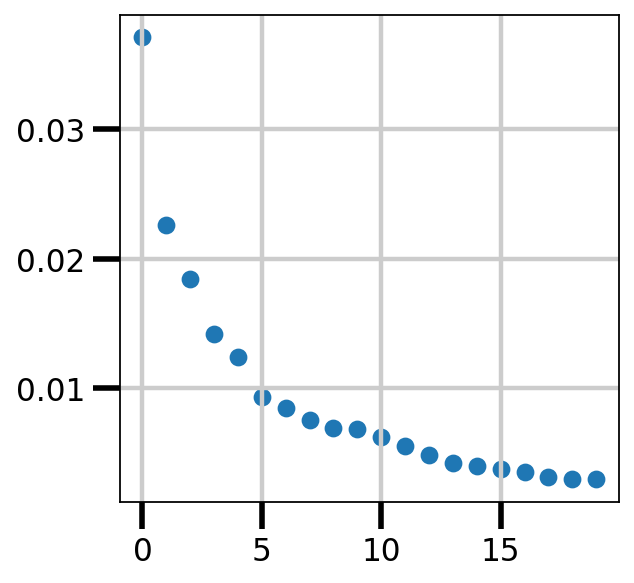

In [28]:
plt.scatter(np.arange(0,len(pca1.explained_variance_ratio_)),pca1.explained_variance_ratio_)

/tmp/ipykernel_466141/1232544368.py:12: RuntimeWarning: divide by zero encountered in log
  axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1,alpha = 0.3, c = np.log(expression_count), cmap = 'rainbow')
/tmp/ipykernel_466141/1232544368.py:12: RuntimeWarning: invalid value encountered in log
  axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1,alpha = 0.3, c = np.log(expression_count), cmap = 'rainbow')


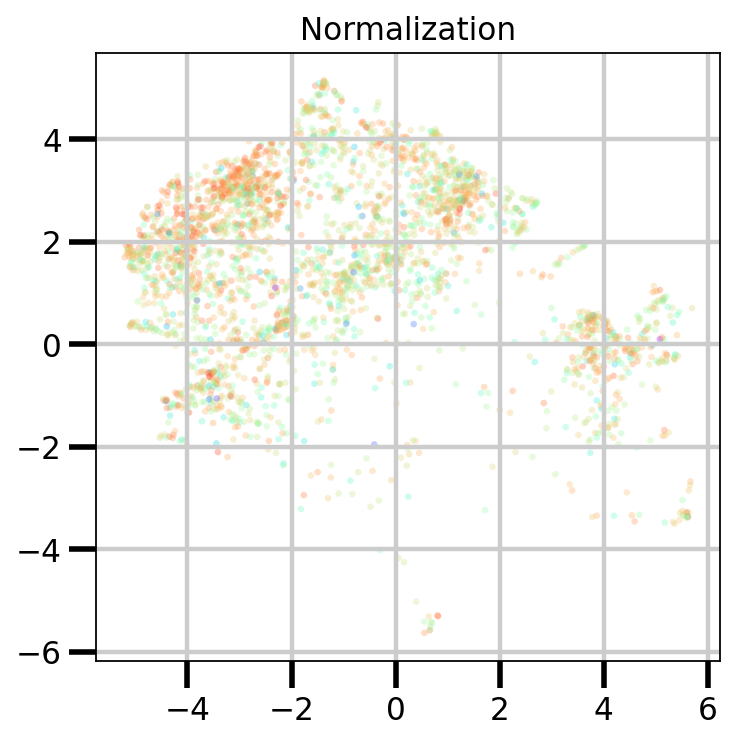

In [29]:
from matplotlib import rcParams
rcParams['figure.figsize']=(5,5)
for i in range(20,21):
    figure, axes = plt.subplots(1,1)
    number_of_components = i
    pca1 = PCA(number_of_components)
    pca1.fit(scaled_data)
    pca_embedding = pca1.transform(scaled_data)
    reducer = umap.UMAP(n_components = 2)
    umap_embedding = reducer.fit_transform(pca_embedding)
    expression_count = np.sum(x.T,axis = 1)
    axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1,alpha = 0.3, c = np.log(expression_count), cmap = 'rainbow')

    axes.set_title('Normalization')
    figure.savefig(os.path.join(figure_path , 'genes_umap_expression_normed_campari_'+str(i)+'.png'))

In [ ]:
gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])

    
marker_genes = ['Ntrk2','Cd34','Nppb','Mrgprb4','Mrgpra3','Mrgprd','Sstr2','Adra2a','Smr2',
                'Bmpr1b','Nefh','Pvalb','Adm',
                'Trpm3','Piezo2','Trpm2','Smr2','Sstr2','Bmpr1b','Trpm8','Trpv1','Piezo2','Piezo1','Nppb',
                'Sst','Pvalb','Prokr2','Mrgprd','Mrgpra3','Cd34',
                'Th','Trpa1','Ntrk3','Ntrk2','Ntrk1','Ret','Tac1','Calca','Calcb','Nefh',
                'S100b','Scn10a','Slc17a8','Atf3','Pou4f3','Calb1','Avil','Asic3',
                'Asic2','Asic1','Pou6f2','Avpr1a','Pou4f2','Sox10','Chrna7','Chrna3',
                'P2rx3','Gfra2','Ldhb','Necab2','Spp1','Adra2a','Chrna7','Tafa4']

marker_position = np.zeros((len(marker_genes),))
count = 0
for marker in  marker_genes:
    index = gene_name.index(marker)
    marker_position[count] = index
    count = count+1

n = 20
nearest_neighbors = np.zeros((n, len(marker_genes)))
nearest_neighbors_distance = np.zeros((n, len(marker_genes)))
auxiliar_distance = np.zeros((umap_embedding.shape[0]))

nearest_neighbors_ = np.zeros((n, len(marker_genes)))
nearest_neighbors_distance_ = np.zeros((n, len(marker_genes)))
auxiliar_distance_ = np.zeros((umap_embedding.shape[0]))

for i in range(len(marker_genes)):
    a = umap_embedding[int(marker_position[i]),:]
    a_ = x.T[int(marker_position[i]),:]
    for j in range(umap_embedding.shape[0]):
        b = umap_embedding[j,:]
        b_ = x.T[j,:]
        dist = np.linalg.norm(a-b)
        auxiliar_distance[j] = dist
        dist_ = np.linalg.norm(a_-b_)
        auxiliar_distance_[j] = dist_
    sorted_arguments = np.argsort(auxiliar_distance)
    nearest_neighbors_distance[:,i] = auxiliar_distance[sorted_arguments[0:n]]
    nearest_neighbors[:,i] = sorted_arguments[0:n].astype(int)
    
    sorted_arguments_ = np.argsort(auxiliar_distance_)
    nearest_neighbors_distance_[:,i] = auxiliar_distance_[sorted_arguments_[0:n]]
    nearest_neighbors_[:,i] = sorted_arguments_[0:n].astype(int)

    
closest_genes = []
for i in range(len(marker_genes)):
    closest_genes_ = []
    for j in range(n):
        closest_genes_.append(gene_name[int(nearest_neighbors[j,i])])
    closest_genes.append(closest_genes_)
 

In [48]:
closest_genes_norm = []
for i in range(len(marker_genes)):
    closest_genes_ = []
    for j in range(n):
        closest_genes_.append(gene_name[int(nearest_neighbors_[j,i])])
    closest_genes_norm.append(closest_genes_)
 

In [53]:
interesting_gene = 'Cd34'

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def complement_intersection(list1,list2):
    non_intersection = list(set(list1) ^ set(list2))
    return non_intersection

index = marker_genes.index(interesting_gene)
closest_genes_for_this = closest_genes[index]
closest_genes_for_this_ = closest_genes_norm[index]

print('Umap:', closest_genes_for_this)
#print('Distance Normalization:', nearest_neighbors_distance[:,index])
print('Normalized Space:' , closest_genes_for_this_)
#print('Distance Normalization + cut:', nearest_neighbors_distance_cut[:,index])
intersection_genes = intersection(closest_genes_for_this,closest_genes_for_this_)
complement_genes = complement_intersection(closest_genes_for_this,closest_genes_for_this_)
print('Intersection:' , intersection_genes)
print('Complement:' , complement_genes)


Umap: ['Cd34', 'D130079A08Rik', 'Gm7271', 'Ighg2c', 'Tafa4', 'Cdh9', 'Kcnd3', 'Spink2', 'AW551984', 'Wfdc2', 'Cacna1i', 'Slc51a', 'Th', 'C1ql4', 'Pde1b', 'AI504432', 'Tmem132e', 'Iqcg', 'Dgkk', 'Slc17a8']
Normalized Space: ['Cd34', 'Tafa4', 'D130079A08Rik', 'Wfdc2', 'Gm7271', 'Rnf112', 'Th', 'Spink2', 'Cacna1i', 'Cdh9', 'Kcnd3', 'Slc51a', 'Rarres1', 'Ighg2c', 'Zfp521', 'Slc17a8', 'Pltp', 'C1ql4', 'AW551984', 'Scin']
Intersection: ['Gm7271', 'Slc17a8', 'Cd34', 'Cacna1i', 'Tafa4', 'Ighg2c', 'Wfdc2', 'D130079A08Rik', 'Spink2', 'AW551984', 'Th', 'C1ql4', 'Slc51a', 'Kcnd3', 'Cdh9']
Complement: ['Iqcg', 'Pltp', 'AI504432', 'Tmem132e', 'Scin', 'Rnf112', 'Dgkk', 'Pde1b', 'Rarres1', 'Zfp521']


In [31]:
#############################################################################################################
#############################################################################################################
#############################################################################################################
#################### HERE WE EXPORT ALL THE INFORMATION FOR GENES AS .MAT ################

data = {'umap_embedding_norm': umap_embedding,'genes': gene_name}
scipy.io.savemat(os.path.join(output_path , 'genes_umap_1.mat'), data)        

#############################################################################################################
#############################################################################################################
#############################################################################################################

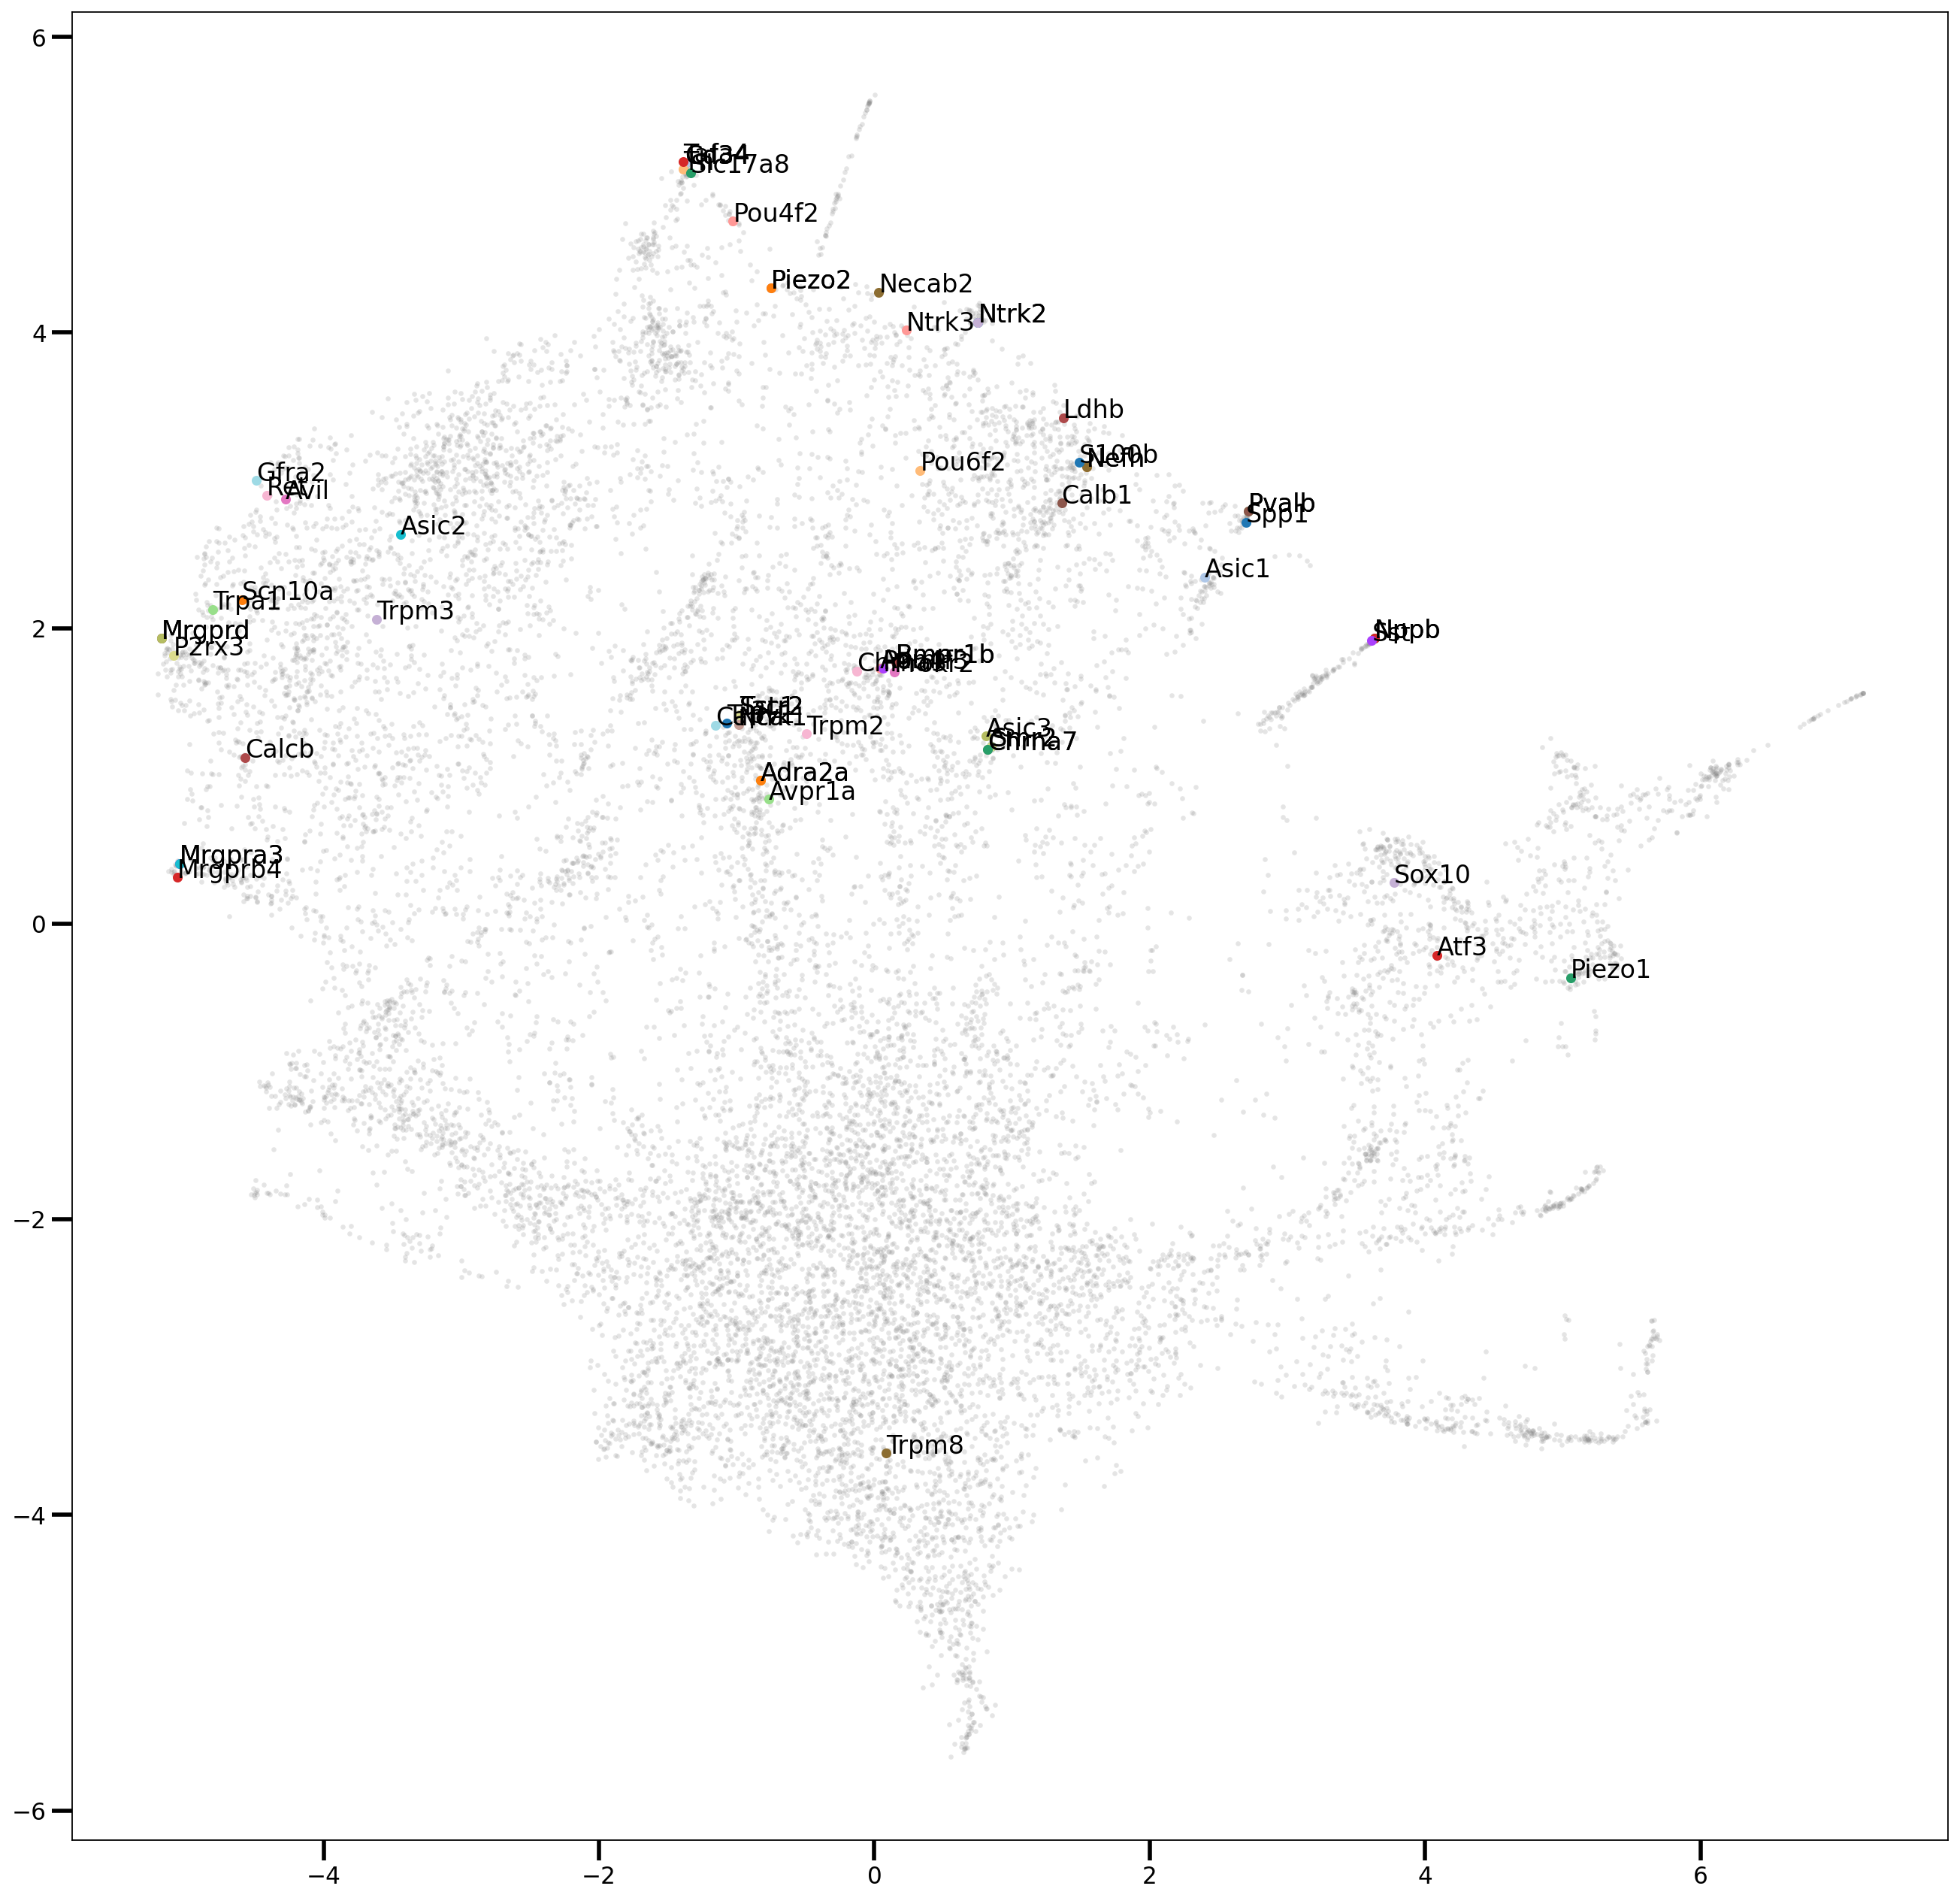

In [38]:
rcParams['figure.figsize']=(20,20)
figure, axes = plt.subplots()

axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1, c = 'gray', alpha = 0.2)
marker_genes_plotting = ['Campari','pinch','new_stroke','ballon','AG','AD','heating','mock',
                         'old_stroke','anal_pinch','mockw__poop',
                        'pinch1','pinch2','pinch3', 'stroke1','stroke2']

marker_genes_plotting = ['Ntrk2','Cd34','Nppb','Mrgprb4','Mrgpra3','Mrgprd','Sstr2','Adra2a','Smr2',
                'Bmpr1b','Nefh','Pvalb','Chrna7','Adm']

marker_genes_plotting = marker_genes

#marker_genes_plotting = ['pinch3', 'stroke1']

for interesting_gene in marker_genes_plotting:
    index = marker_genes.index(interesting_gene)
    closest_genes_for_this = closest_genes[index]
    #axes.scatter(umap_embedding[nearest_neighbors[1:,index].astype(int),0],umap_embedding[nearest_neighbors[1:,index].astype(int),1], s= 1, c = 'k')
    axes.scatter(umap_embedding[nearest_neighbors[0,index].astype(int),0],umap_embedding[nearest_neighbors[0,index].astype(int),1], s= 15)
    axes.annotate(interesting_gene, (umap_embedding[nearest_neighbors[0,index].astype(int),0], umap_embedding[nearest_neighbors[0,index].astype(int),1]),fontsize = 15, color= 'k')
axes.grid(False)
#axes.legend(['','Campari','pinch','new_stroke','ballon','AG','AD','heating','mock',
#             'old_stroke','anal_pinch','mockw__poop','pinch1','pinch2','pinch3', 'stroke1','stroke2'],bbox_to_anchor=(1.1, 1.05))

#axes.legend(['','Ntrk2','Cd34','Nppb','Mrgprb4','Mrgpra3','Mrgprd','Sstr2','Adra2a','Smr2',
#                'Bmpr1b','Nefh','Pvalb','Chrna7','Adm'],bbox_to_anchor=(1.1, 1.05))

#axes.legend(['','pinch3','stroke1'],bbox_to_anchor=(1.1, 1.05))

figure.savefig(os.path.join(figure_path , 'genes_umap_norm.png'))

NameError: name 'umap_embedding_cut' is not defined

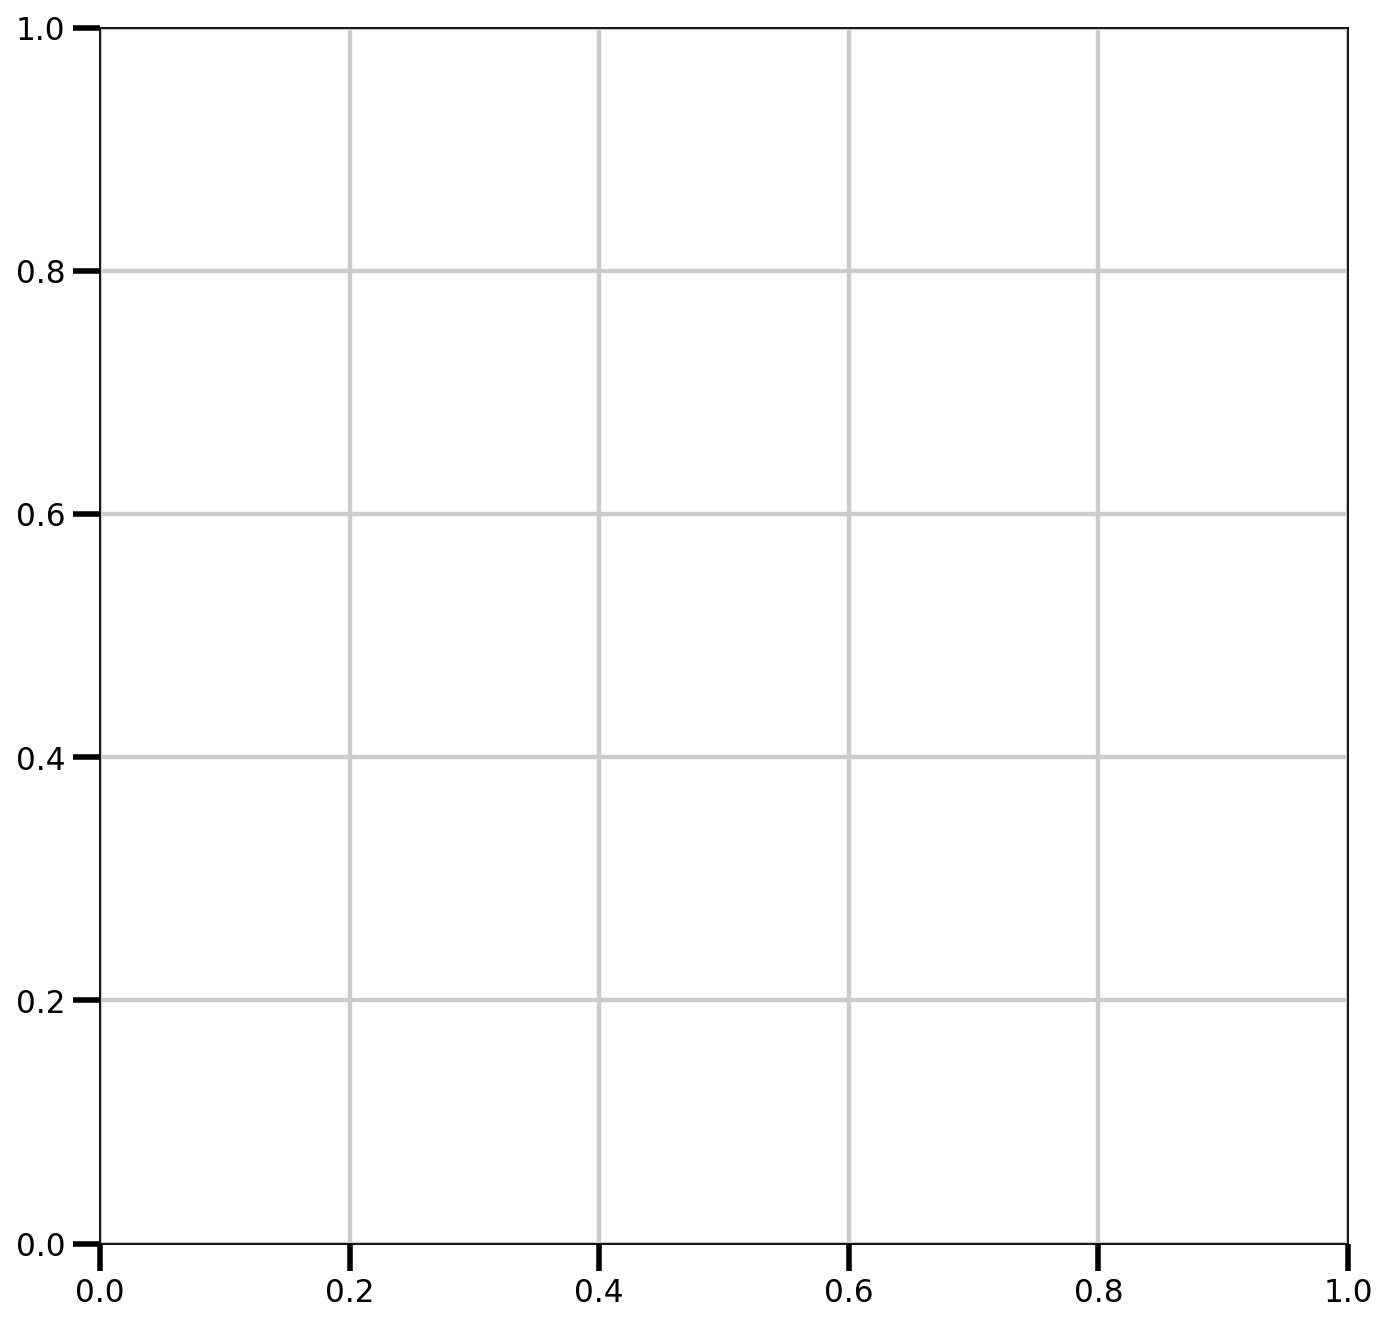

In [33]:
#rcParams['figure.figsize']=(12,12)
figure, axes = plt.subplots()

axes.scatter(umap_embedding_cut[:,0],umap_embedding_cut[:,1], s= 1, c = 'gray', alpha = 0.2)

for interesting_gene in marker_genes_plotting:
    index = marker_genes.index(interesting_gene)
    closest_genes_for_this = closest_genes_cut[index]
    #axes.scatter(umap_embedding_cut[nearest_neighbors_cut[1:,index].astype(int),0],umap_embedding_cut[nearest_neighbors_cut[1:,index].astype(int),1], s= 1, c = 'k')
    axes.scatter(umap_embedding_cut[nearest_neighbors_cut[0,index].astype(int),0],umap_embedding_cut[nearest_neighbors_cut[0,index].astype(int),1], s= 5)
    #axes.annotate(interesting_gene, (umap_embedding_cut[nearest_neighbors_cut[0,index].astype(int),0], umap_embedding_cut[nearest_neighbors_cut[0,index].astype(int),1]),fontsize = 12, color= 'k')
axes.grid(False)
#axes.legend(['','Campari','pinch','new_stroke','ballon','AG','AD','heating','mock',
#             'old_stroke','anal_pinch','mockw__poop','pinch1','pinch2','pinch3', 'stroke1','stroke2'],bbox_to_anchor=(1.1, 1.05))


#axes.legend(['','Ntrk2','Cd34','Nppb','Mrgprb4','Mrgpra3','Mrgprd','Sstr2','Adra2a','Smr2',
#                'Bmpr1b','Nefh','Pvalb'],bbox_to_anchor=(1.1, 1.05))

axes.legend(['','pinch3','stroke1'],bbox_to_anchor=(1.1, 1.05))

figure.savefig(os.path.join(figure_path , 'genes_umap_normcut_selected_stim.png'))

In [42]:
gene = 'Th'
index = marker_genes.index(gene)
closest_genes[index]

['Th',
 'Slc51a',
 'AW551984',
 'Kcnd3',
 'Cdh9',
 'Spink2',
 'Ighg2c',
 'AI504432',
 'Wfdc2',
 'Iqcg',
 'Chrna4',
 'Pde1b',
 'Cacna1i',
 'Cd34',
 'C1ql4',
 'Ceacam10',
 'Sema3e',
 'Cdh10',
 'D130079A08Rik',
 'Tafa4']